### Exploraty Data Analysis (EDA)
Check if sentiment patterns line up with stock moves.

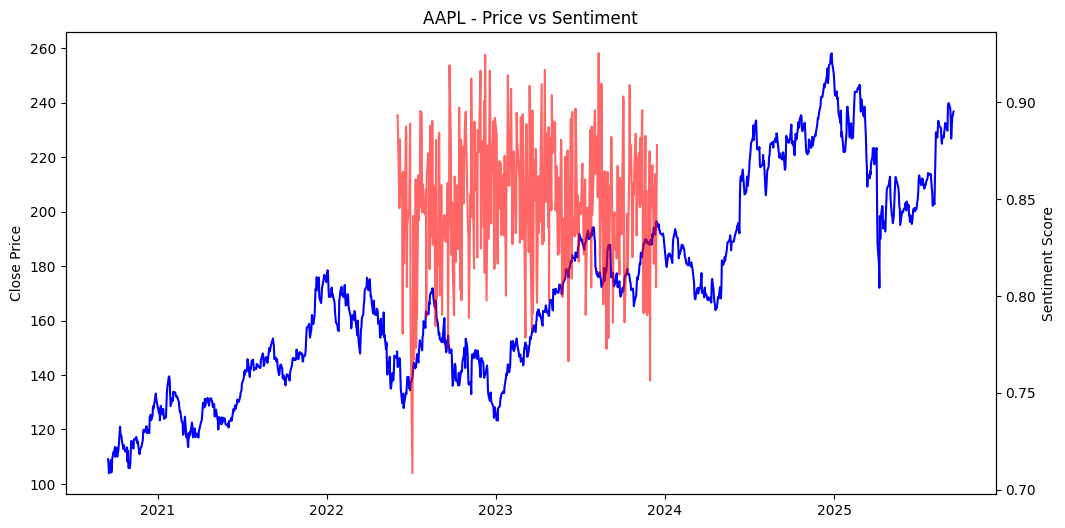

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

merged = pd.read_csv("../data/processed/stocks_news_merged.csv")
merged["Date"] = pd.to_datetime(merged["Date"])

# Compute daily returns
merged["Return"] = merged.groupby("Ticker")["Close"].pct_change()

# Plot prices vs sentiment
fig, ax1 = plt.subplots(figsize=(12,6))
ticker = "AAPL"
df_t = merged[merged["Ticker"] == ticker]

ax1.plot(df_t["Date"], df_t["Close"], color="blue", label="Close Price")
ax2 = ax1.twinx()
ax2.plot(df_t["Date"], df_t["avg_sentiment_score"], color="red", alpha=0.6, label="Sentiment")

ax1.set_title(f"{ticker} - Price vs Sentiment")
ax1.set_ylabel("Close Price")
ax2.set_ylabel("Sentiment Score")
plt.show()


Use lagged sentiment (yesterday's news sentiment)
Predict if the next day's return is positive or negative
Give a baseline accuracy and classification metrics

### Train a logistic regression model

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Load merged dataset
merged = pd.read_csv("../data/processed/stocks_news_merged.csv")
merged["Date"] = pd.to_datetime(merged["Date"])

# Create daily returns
merged["Return"] = merged.groupby("Ticker")["Close"].pct_change()

# Lag sentiment to avoid lookahead bias
merged["Sentiment_lag1"] = merged.groupby("Ticker")["avg_sentiment_score"].shift(1)

# Target: Up (1) if return > 0, else Down (0)
merged["UpDown"] = (merged["Return"] > 0).astype(int)

# Drop NaN rows
df = merged.dropna(subset=["Sentiment_lag1", "Return", "UpDown"])

# Features & target
X = df[["Sentiment_lag1"]]
y = df["UpDown"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)

# Predictions
y_pred = clf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5172413793103449
              precision    recall  f1-score   support

           0       0.43      0.11      0.18        54
           1       0.53      0.87      0.66        62

    accuracy                           0.52       116
   macro avg       0.48      0.49      0.42       116
weighted avg       0.48      0.52      0.43       116



Conclusion: The logistic regression is biased toward predicting Up days. That’s why recall for class 1 is so high, but recall for class 0 is terrible.

### Improve the model

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression

# Compute balanced weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

# Create a dictionary mapping class labels to weights
weights_dict = dict(zip(np.unique(y_train), class_weights))
print("Class weights:", weights_dict)

# Train logistic regression with balanced weights
clf_balanced = LogisticRegression(class_weight=weights_dict, max_iter=1000)
clf_balanced.fit(X_train_scaled, y_train)

# Predictions
y_pred_balanced = clf_balanced.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced))


Class weights: {0: 1.0919811320754718, 1: 0.9223107569721115}
Accuracy: 0.49137931034482757
              precision    recall  f1-score   support

           0       0.45      0.39      0.42        54
           1       0.52      0.58      0.55        62

    accuracy                           0.49       116
   macro avg       0.48      0.48      0.48       116
weighted avg       0.49      0.49      0.49       116

